## Objective: The objective of this step is that given the repository of Research Papers, if we can utilize an Unsupervised method to cluster them into insightful groups based on genre.

For example, Research Papers regarding topics concerning impacts on Mass Gatherings or Travelling Abroad durings pandemics may be clustered together to form a cluster. 

Below are few examples of Research Paper titles:
1. Yellow fever outbreaks, vaccine shortages and the Hajj and Olympics: call for global vigilance
2. Chapter 7 The Games of the XXVII Olympiad in Sydney (2000)
3. Mass gatherings and respiratory disease
4. Assessment of Temporary Community-Based Health Care Facilities During Arbaeenia Mass Gathering at Karbala, Iraq: Cross-Sectional Survey Study

## Methodology: Graph Based Overlapping Clustering

Reference: https://github.com/benedekrozemberczki/EgoSplitting

We are using the a NetworkX implementation of "Ego-splitting Framework" to categorize the Research Papers into clusters.  This framework is developed by Alessandro Epasto, Silvio Lattanzi and Renato Paes Leme for detecting clusters in complex networks which leverage the local structures known as ego-nets (i.e. the subgraph induced by the neighborhood of each node) to de-couple overlapping clusters. Ego-splitting is a highly scalable and flexible framework, with provable theoretical guarantees, that reduces the complex overlapping clustering problem to a simpler and more amenable non-overlapping (partitioning)problem.

Ego-splitting framework works in two steps: a local ego-net analysis and a global graph partitioning

Ego-Splitting Framework Paper: https://www.eecs.yorku.ca/course_archive/2017-18/F/6412/reading/kdd17p145.pdf

## Step I: Build the Network for the Research Paper Repository
In this network, **each Node is a Research Paper** and there will be an edge between two Nodes only if there exists some kind of relationship between the two Research Papers. The relationships can exist in two cases:
1. If one Research Paper is referenced in the other Research Paper
2. If the cosine similarity of the document embedding of the two Research Papers is higher than or equal to 0.9

Embedding Used: BioSentVec (https://github.com/ncbi-nlp/BioSentVec)

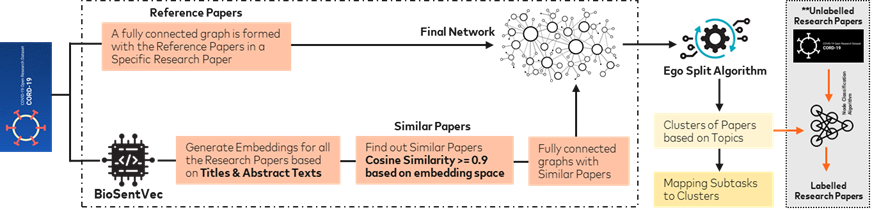

## ~CODE~

In [ ]:
!pip install yake
!pip install langdetect

In [ ]:
import numpy as np
import pandas as pd
import os
import argparse
import json
import torch
import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
from texttable import Texttable
import yake

import community
from tqdm import tqdm
from itertools import combinations
import itertools
import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from itertools import permutations, combinations

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
from nltk.tokenize import sent_tokenize, word_tokenize
import ast
from collections import Counter

## Inputs:
1. **ALL_study_with_wiki_columns.pkl:** This file contains keywords extracted from the Title of the Research Paper based on Wikifier
2. **res_ref.csv:** This file contains the relationship among research papers depending on whether one is referenced in another
3. **title.csv:** This file contains the Title of the Research Papers along with their distinct PID (Identity Variable)
4. **result.pkl:** This file contains contains the edgelist of the network

In [ ]:
read_data_All = pd.read_pickle('/kaggle/input/inputs-covid-clustering/ALL_study_with_wiki_columns.pkl')
ref_table = pd.read_pickle('/kaggle/input/inputs-covid-clustering/res_ref.pkl')
main_Data_csv = pd.read_csv('/kaggle/input/inputs-covid-clustering/title_rp.csv')
edge_list = pd.read_pickle('/kaggle/input/inputs-covid-clustering/result__1.pkl')

In [ ]:
#Functions to Extract Wikifier Keywords and the Category of the Keywords in a List Format

def extract_response_title(response):
    all_wrds=[]
    try:
        for annotation in response["annotations"]:
            if annotation["cosine"]>0.1:
                if len(annotation["dbPediaTypes"])>0:
                    all_wrds.append(annotation["title"])
    except:
        1==1
    return [key for key, value in Counter(all_wrds).most_common()] 

def extract_response_val(response):
    all_wrds=[]
    try:
        for annotation in response["annotations"]:
            if annotation["cosine"]>0.1:
                all_wrds.append(annotation["dbPediaTypes"])
    except:
        1==1
    all_wrds=[k for j in all_wrds for k in j ]
    return [key for key, value in Counter(all_wrds).most_common()]  

### Merge all the Information to save the final Graph Edges along with detailed Information like Research Paper Title, Keywords Extracted, Category of Keywords Extracted etc.

In [ ]:
read_data_All['title_kw']=read_data_All['all_txt_resp'].apply(lambda x: extract_response_title(x))
read_data_All['Cat_mach']=read_data_All['all_txt_resp'].apply(lambda x: extract_response_val(x))
read_data_All=read_data_All[['title','title_kw','Cat_mach']]
read_data_All.head(2)

In [ ]:
main_Data_csv_new = main_Data_csv.merge(ref_table,left_on='sha',right_on='paper_id',how='inner')
main_Data_csv_new = main_Data_csv_new.merge(main_Data_csv_new[['pid','title_x']].drop_duplicates(),left_on=['ref_title_y'],right_on=['title_x'],how='inner')
main_Data_csv_new = main_Data_csv_new[['pid_x','pid_y']]

edge_list.columns = ['pid_x','pid_y']
edge_list = edge_list.append(main_Data_csv_new)
edge_list = edge_list.merge(main_Data_csv,left_on='pid_x',right_on='pid',how='left')
read_data_All = read_data_All.merge(main_Data_csv[['pid','title']],on='title',how='right')

#Save to Pickle Files
# ref_table.to_pickle('Graph_adj_matrix.pkl')
# read_data_All.to_pickle('Graph_kw_matrix.pkl')

In [ ]:
# Find out the PIDs of Research Papers which occurs more than once in the Repository

read_data_All['title_kw'] = read_data_All['title_kw'].apply(lambda x:str(x))
read_data_All['Cat_mach'] = read_data_All['Cat_mach'].apply(lambda x:str(x))
check_ = read_data_All.groupby(by = 'pid', as_index = False)['title_kw'].count().sort_values(by = 'title_kw', ascending = False)
remove_pid = list(check_[check_['title_kw'] > 1]['pid'])

#Save to Pickle Files
pd.DataFrame(remove_pid).to_pickle('Remove_PID.pkl')

#Remove these PIDs from the Final Graph Edge List
skills_cluster_file = edge_list[['pid_x','pid_y']]
skills_cluster_file = skills_cluster_file[~skills_cluster_file['pid_x'].isin(remove_pid)].reset_index(drop = True)
skills_cluster_file = skills_cluster_file[~skills_cluster_file['pid_y'].isin(remove_pid)].reset_index(drop = True)

### Build the Final Network from the Edge List
The Ego-Split Algorithm code takes the **edge list** of the graph in a csv file. Every row indicates an edge between two nodes separated by a comma. The first row is a header. Nodes should be indexed starting with 0. 

In [ ]:
graph = nx.from_edgelist(skills_cluster_file.values.tolist())

## Step II: Ego-Split Algorithm

Reference: https://github.com/benedekrozemberczki/EgoSplitting

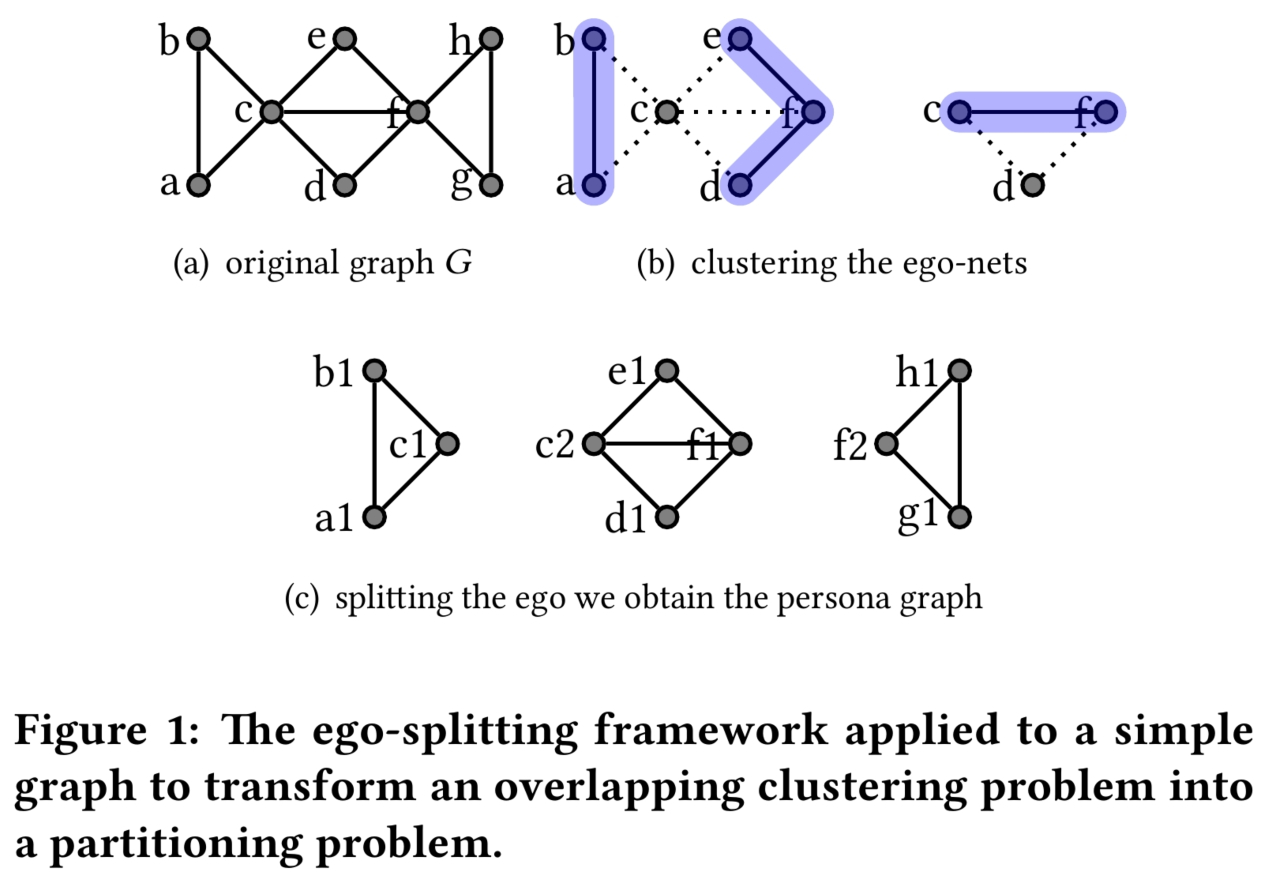

In [ ]:
class EgoNetSplitter(object):
    """
    A lightweight implementation of "Ego-Splitting Framework: from Non-Overlapping to Overlapping Clusters". 
    Paper: https://www.eecs.yorku.ca/course_archive/2017-18/F/6412/reading/kdd17p145.pdf
    Video: https://www.youtube.com/watch?v=xMGZo-F_jss
    Slides: https://epasto.org/papers/kdd2017-Slides.pdf
    """
    def __init__(self, graph, resolution):
        """
        :param graph: Networkx object.
        :param resolution: Resolution parameter of Python Louvain.
        """
        self.graph = graph
        self.resolution = resolution

    def create_egonet(self, node):
        """
        Creating an ego net, extracting personas and partitioning it.
        :param node: Node ID for egonet (ego node).
        """
        ego_net_minus_ego = self.graph.subgraph(self.graph.neighbors(node))
        components = {i: nodes for i, nodes in enumerate(nx.connected_components(ego_net_minus_ego))}
        new_mapping = {}
        personalities = []
        for k, v in components.items():
            personalities.append(self.index)
            for other_node in v:
                new_mapping[other_node] = self.index 
            self.index = self.index +1
        self.components[node] = new_mapping
        self.personalities[node] = personalities

    def create_egonets(self):
        """
        Creating an egonet for each node.
        """
        self.components = {}
        self.personalities = {}
        self.index = 0
        print("Creating egonets.")
        for node in tqdm(self.graph.nodes()):
            self.create_egonet(node)

    def map_personalities(self):
        """
        Mapping the personas to new nodes.
        """
        self.personality_map = {persona: node for node in self.graph.nodes() for persona in self.personalities[node]}

    def create_persona_graph(self):
        """
        Create a persona graph using the egonet components.
        """
        print("Creating the persona graph.")
        self.persona_graph_edges = [(self.components[edge[0]][edge[1]], self.components[edge[1]][edge[0]]) for edge in tqdm(self.graph.edges())]
        self.persona_graph = nx.from_edgelist(self.persona_graph_edges)

    def create_partitions(self):
        """
        Creating a non-overlapping clustering of nodes in the persona graph.
        """
        print("Clustering the persona graph.")
        self.partitions = community.best_partition(self.persona_graph, resolution=self.resolution)
        self.overlapping_partitions = {node: [] for node in self.graph.nodes()}
        for node, membership in self.partitions.items():
            self.overlapping_partitions[self.personality_map[node]].append(membership)

## Function to Trying out Clustering at Different Resolutions

In [ ]:
def create_clusters_(x):
    print('Resolution : ',x)
    splitter = EgoNetSplitter(graph, x)
    splitter.create_egonets()
    splitter.map_personalities()
    splitter.create_persona_graph()
    splitter.create_partitions()

    b = list(splitter.overlapping_partitions.values())
    
    ego_focal_points = []
    for vals in b:
        ego_focal_points.extend(vals)

    c = list(set(ego_focal_points))

    node_df = pd.DataFrame({'nodes':list(splitter.overlapping_partitions.keys()), 'focal_points':list(splitter.overlapping_partitions.values())})
    for vals in c:
        node_df[vals] = node_df['focal_points'].apply(lambda x:x.count(vals))
        
    node_df['count_focal_points'] = node_df['focal_points'].apply(lambda x:len(x))

    cl_ = list(node_df['focal_points'])

    c_ = []
    for ele in cl_:
        c_.extend(ele)

    c_ = list(set(c_))
    num_nodes = max(c_)

    sk_ = []
    for i in range(num_nodes):
        sk_.append(list(node_df[node_df[i] == 1]['nodes']))

    sk__ = pd.DataFrame(columns = ['nodes_in_cluster'])
    sk__['nodes_in_cluster'] = sk_

    sk__['cluster'] = sk__.index
    sk__['total_cluster_size']=sk__['nodes_in_cluster'].apply(lambda x:len(x))
    
    print(sk__[sk__['total_cluster_size'] > 5].shape)
    file_name = 'Save_Clusters_Res_'+str(x)+'.pkl'
    sk__[sk__['total_cluster_size'] > 5].sort_values(by = 'total_cluster_size', ascending = False).to_pickle(file_name)
    print('----------------------------------------------------------------------')
    
list_res = [0.1, 0.8, 0.03]
for res in list_res:
    create_clusters_(res)

In [ ]:
def unstack_(dataframe, column_name):
    lst_col = column_name
    dataframe = pd.DataFrame({col:np.repeat(dataframe[col].values, dataframe[lst_col].str.len())for col in dataframe.columns.difference([lst_col])}).assign(**{lst_col:np.concatenate(dataframe[lst_col].values)})[dataframe.columns.tolist()]
    return dataframe

## Additional Operations:
Additionally we are also performing the following Operations to analyze the clusters formed in a better and efficient way.

1. Extract Additional Keywords from all the Titles of the Research Papers. We are using 'yake' for this (https://pypi.org/project/yake-github/)
2. Extract the top 5 Research Papaers from each Cluster based on Page Rank algorithm.

To know more about Page Rank Algorithms, please refer to:

1. https://www.geeksforgeeks.org/page-rank-algorithm-implementation/
2. https://www.link-assistant.com/news/google-page-rank-2019.html
3. https://www.searchenginewatch.com/2018/10/25/googles-pagerank-algorithm-explained/

In [ ]:
#Function to extract Keywords using yake package
def yake_generator(text):
    text = re.sub(r'Â',"",text)
    text = re.sub(r'©',"",text)
    text = re.sub(r'®',"",text)
    text = re.sub(r'â',"",text)
    text = re.sub(r'¢',"",text)
    text = re.sub(r'€',"",text)
    language = "en"
    max_ngram_size = 4
    deduplication_thresold = 0.7
    deduplication_algo = 'jaro' #'jaro'
    windowSize = 3
    numOfKeywords = 10

    custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_thresold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)
    keywords = custom_kw_extractor.extract_keywords(text)
    keywords1=[]
    for kw in keywords:
        strt=kw[1]
        keywords1.append(strt)
    keywrd_ext=[]
    for wrd in keywords1:
        wrd=re.sub('\s+',' ',wrd).strip()
        pat = re.compile(r"([.()!?,;/\'])")
        wrd=pat.sub("", wrd)
        wrd=re.sub('@','',wrd).strip()
        keywrd_ext.append(wrd)
        
    final_final_list=[]
    for k in keywrd_ext:
        doc = word_tokenize(k)
        li=[w for w in doc if w.isalpha()]
        wrd=""
        if len(li)>0:
            wrd=" ".join(li)
            final_final_list.append(wrd)
    return final_final_list


In [ ]:
read_data_All.head()

In [ ]:
read_data_All = read_data_All[~read_data_All['pid'].isin(remove_pid)].reset_index(drop = True)
read_data_All['title_'] = read_data_All['title'].apply(lambda x:x.strip('Chapter '))
read_data_All['title_'] = read_data_All['title_'].apply(lambda x:x.replace('volume',''))
read_data_All['title_'] = read_data_All['title_'].apply(lambda x:x.replace('Volume',''))
read_data_All['title_'] = read_data_All['title_'].apply(lambda x:x.replace('ontents',''))
read_data_All['keywords'] = read_data_All['title_'].apply(lambda x:yake_generator(x))

#Finding out the Language in which the Research Paper is written
#read_data_All['lang'] = read_data_All['title_'].apply(lambda x: detect(str(x))) 

read_data_All['title_kw'] = read_data_All['title_kw'].apply(lambda x:x[2:-2].split("', '"))
read_data_All['Cat_mach'] = read_data_All['Cat_mach'].apply(lambda x:x[2:-2].split("', '"))

In [ ]:
def generate_detailed_clusters_keywords(dataframe):
    print('File Name : ', dataframe)
    cluster_1 = pd.read_pickle(dataframe)
    cluster_1 = cluster_1[['nodes_in_cluster','cluster','total_cluster_size']]

    #cluster_1['nodes_in_cluster'] =  cluster_1['nodes_in_cluster'].apply(lambda x: ast.literal_eval(x))
    skills_in_cluster_int = cluster_1['nodes_in_cluster'].to_list()
    
    print('----------------------------------')
    print('Gettin Top N Research Papers')
    cluster_node = []

    for each_cluster in skills_in_cluster_int:
        H = graph.subgraph(each_cluster)
        pr = nx.pagerank_numpy(H, alpha=0.9)
        ## You can take Top K from the Dictionary 'pr'.
        top_rank = list(pd.DataFrame({'nodes':list(pr.keys()),'values':list(pr.values())}).sort_values(by = 'values', ascending = False).reset_index(drop = True)[:5]['nodes'])
        cluster_node.append(top_rank)

    cluster_1['Top_rank_node'] = cluster_node
    
    print('----------------------------------')
    print('Unstacking & Merging')
    
    cluster_1 = unstack_(cluster_1, 'nodes_in_cluster')
    cluster_1['top_nodes'] = cluster_1.apply(lambda z:1 if z.Top_rank_node.count(z.nodes_in_cluster) != 0 else 0, axis = 1)
    cluster_1 = cluster_1[['nodes_in_cluster', 'cluster', 'total_cluster_size', 'top_nodes']]
    
    cluster_1 = cluster_1.merge(read_data_All, right_on = 'pid', left_on = 'nodes_in_cluster', how = 'left')
    cluster_1 = cluster_1[['nodes_in_cluster', 'cluster', 'total_cluster_size', 'top_nodes',
           'title', 'title_kw', 'Cat_mach', 'keywords']]
    
    save_file_name = dataframe.strip('.xlsx')+('_dc.xlsx')
    cluster_1.to_excel(save_file_name)
    
    print('----------------------------------')
    print('Getting Top Keywords')
    
    skills_in_cluster_int = list(cluster_1['cluster'].unique())
    
    cluster_dict = []
    for each_cluster in skills_in_cluster_int:
        keywords_extracted = list(itertools.chain(*list(cluster_1[cluster_1['cluster'] == each_cluster]['keywords'])))
        keywords_extracted_unique = list(set(keywords_extracted))
        counts = []
        for words_ in keywords_extracted_unique:
            counts.append(keywords_extracted.count(words_))

        kc = pd.DataFrame({'keywords':keywords_extracted_unique,'count':counts}).sort_values(by = 'count', ascending = False)
        kc = kc[kc['count'] > 2].reset_index(drop = True)


        cluster_dict.append(dict(zip(list(kc['keywords']), list(kc['count']))))
        
    KW = pd.DataFrame({'cluster':skills_in_cluster_int,'keywords':cluster_dict})
    
    print('----------------------------------')
    print('Getting Top Title Keywords')
    
    skills_in_cluster_int = list(cluster_1['cluster'].unique())
    
    cluster_dict = []
    for each_cluster in skills_in_cluster_int:
        keywords_extracted = list(itertools.chain(*list(cluster_1[cluster_1['cluster'] == each_cluster]['title_kw'])))
        keywords_extracted_unique = list(set(keywords_extracted))
        counts = []
        for words_ in keywords_extracted_unique:
            counts.append(keywords_extracted.count(words_))

        kc = pd.DataFrame({'keywords':keywords_extracted_unique,'count':counts}).sort_values(by = 'count', ascending = False)
        kc = kc[kc['count'] > 2].reset_index(drop = True)


        cluster_dict.append(dict(zip(list(kc['keywords']), list(kc['count']))))
        
    TKW = pd.DataFrame({'cluster':skills_in_cluster_int,'titlekeywords':cluster_dict})
    
    print('----------------------------------')
    print('Getting Top Title Match')
    
    skills_in_cluster_int = list(cluster_1['cluster'].unique())
    
    cluster_dict = []
    for each_cluster in skills_in_cluster_int:
        keywords_extracted = list(itertools.chain(*list(cluster_1[cluster_1['cluster'] == each_cluster]['Cat_mach'])))
        keywords_extracted_unique = list(set(keywords_extracted))
        counts = []
        for words_ in keywords_extracted_unique:
            counts.append(keywords_extracted.count(words_))

        kc = pd.DataFrame({'keywords':keywords_extracted_unique,'count':counts}).sort_values(by = 'count', ascending = False)
        kc = kc[kc['count'] > 2].reset_index(drop = True)


        cluster_dict.append(dict(zip(list(kc['keywords']), list(kc['count']))))
        
    TKM = pd.DataFrame({'cluster':skills_in_cluster_int,'title_match':cluster_dict})
    
    T = KW.merge(TKW).merge(TKM)
    save_file_name = dataframe.strip('.xlsx')+('_topkw.xlsx')
    T.to_excel(save_file_name)
    print('----------------------------------')
    

In [ ]:
def _generate_filename(x):
    return 'Save_Clusters_Res_'+str(x)+'.pkl'
list_res_ = list(map(_generate_filename,list_res))

for files in list_res_:
    generate_detailed_clusters_keywords(files)

## Additional Changes based on Updates in the Research Papers Repository

In [ ]:
#New Repositiory of Research Papers with CORD_UID variable for all the Research Papers
metadata = pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv')
metadata = metadata[['cord_uid','title']]
metadata.columns = ['cord_uid', 'Title']

#Read the File with the Final Clusters
cluster_file_all = pd.read_csv('/kaggle/input/inputs-covid-clustering/Final_Clusters_Keywords.csv')

#Merge both the Files and Save
cluster_file_all.merge(metadata, how = 'left').to_csv(('Final_Clusters_Keywords_UID.csv'))